In [1]:
#%env CUDA_VISIBLE_DEVICES ""      # Rendering on CPU is approx. 10x slower
%env CUDA_VISIBLE_DEVICES 2

from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from utils.load_blender import pose_spherical, pose_spherical2
import run_dnerf
from run_dnerf import render_path, device, render
from run_dnerf_helpers import to8b
from utils import Arrow3D, draw_transformed, draw_cam

%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=2
[Import] Using CUDA version 10.2 on GeForce GTX 1080 Ti with global GPU index 2


In [2]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')           # Use this when on GPU

# get config file
# config_file = "configs/johannes.txt"
config_file = "logs/gobblet_05_mse_dgs_hardcoded/config.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
# hwff = [480, 360, 398.907, 398.907]
hwff = [480, 640, 398.907, 398.907]
# hwf = [480, 640, 574]
# hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 0.1, 'far' : 2.1})
# render_kwargs_test.update({'near' : 2., 'far' : 6.})

[Config] NeRF type selected: direct_temporal
[Info] Found ckpts:
		./logs/gobblet_05_mse_dgs_hardcoded/300000.tar
[Config] Reloading from ./logs/gobblet_05_mse_dgs_hardcoded/300000.tar


## Generate Frame

In [41]:
def generate_img(time, azimuth, elevation, depth):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    # render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, depth), 0).to(device)
    render_poses = torch.unsqueeze(pose_spherical2(azimuth, elevation, depth), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0], render_poses[0]

In [52]:
render_times = torch.Tensor([0]).to(device)

render_poses = torch.unsqueeze(torch.Tensor([[ 0.9633663 , -0.06913885, -0.25912374, -0.18290284],
       [ 0.00335968,  0.96923393, -0.24611846,  0.11034248],
       [ 0.26816785,  0.23623165,  0.93395984,  0.5101595 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 0).to(device)

with torch.no_grad():
        rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)
        # rgb, disp, acc, depth, _ = render(*hwff, chunk=args.chunk, c2w=render_poses[0][:3,:4], frame_time=render_times[0], **render_kwargs_test)
img = to8b(rgbs)[0]
# img = to8b(rgb)[0]
render_pose = render_poses[0]

100%|██████████| 1/1 [00:14<00:00, 14.10s/it]


In [53]:
render_times, render_pose

(tensor([0.]),
 tensor([[ 0.9634, -0.0691, -0.2591, -0.1829],
         [ 0.0034,  0.9692, -0.2461,  0.1103],
         [ 0.2682,  0.2362,  0.9340,  0.5102],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]))

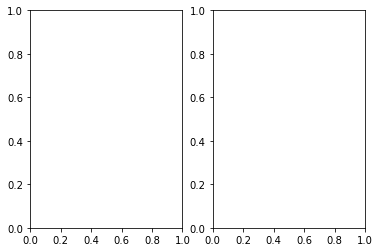

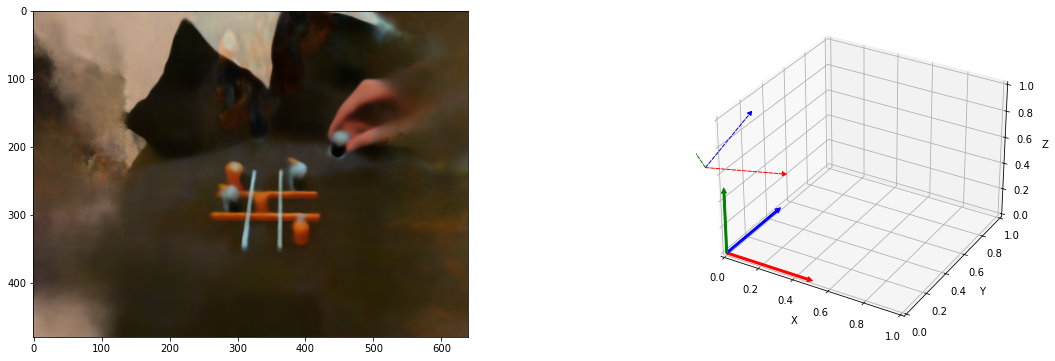

In [54]:
# HUMAN SCENE
# time = 0.55  # in [0,1]
# azimuth = -50  # in [-90,0]      
# elevation = -25  # in [-45,45]
# SCENE_OBJECT_DEPTH = 1.5

# GAME SCENE
time = 0.6  # in [0,1]
azimuth = -30  # in [-180,-90]      
elevation = 20  # in [-45,45]
SCENE_OBJECT_DEPTH = 0.7

# img, render_pose = generate_img(time, azimuth, elevation, depth=SCENE_OBJECT_DEPTH)

fig = plt.figure(figsize=(20,6))

ax0 = fig.add_subplot(121)
ax0.imshow(img)

ax1 = fig.add_subplot(122, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
arrow_prop_dict = dict(mutation_scale=10, arrowstyle='simple', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, .5], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, .5], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, .5], **arrow_prop_dict, color='g'))
tcx, tcy, tcz, _ = draw_transformed(render_pose.cpu().numpy(), ax1, linestyle="--", axes_len=0.5, mutation_scale=10)

plt.show();